[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/chatbot-external-memory.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239440-lesson-6-chatbot-w-summarizing-messages-and-external-memory)

# Chatbot with message summarization & external DB memory

## Review

We've covered how to customize graph state schema and reducer. 
 
We've also shown a number of tricks for trimming or filtering messages in graph state. 

We've used these concepts in a Chatbot with memory that produces a running summary of the conversation.

## Goals

But, what if we want our Chatbot to have memory that persists indefinitely?

Now, we'll introduce some more advanced checkpointers that support external databases. 

Here, we'll show how to use [Sqlite as a checkpointer](https://langchain-ai.github.io/langgraph/concepts/low_level/#checkpointer), but other checkpointers, such as [Postgres](https://langchain-ai.github.io/langgraph/how-tos/persistence_postgres/) are available!

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph-checkpoint-sqlite langchain_core langgraph langchain_openai

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

## Sqlite

A good starting point here is the [SqliteSaver checkpointer](https://langchain-ai.github.io/langgraph/concepts/low_level/#checkpointer).

Sqlite is a [small, fast, highly popular](https://x.com/karpathy/status/1819490455664685297) SQL database. 
 
If we supply `":memory:"` it creates an in-memory Sqlite database.

In [3]:
import sqlite3
# In memory
conn = sqlite3.connect(":memory:", check_same_thread = False)

But, if we supply a db path, then it will create a database for us!

In [4]:
# pull file if it doesn't exist and connect to local db
!mkdir -p state_db && [ ! -f state_db/example.db ] && wget -P state_db https://github.com/langchain-ai/langchain-academy/raw/main/module-2/state_db/example.db

db_path = "state_db/example.db"
conn = sqlite3.connect(db_path, check_same_thread=False)

In [5]:
# Here is our checkpointer 
from langgraph.checkpoint.sqlite import SqliteSaver
memory = SqliteSaver(conn)

Let's re-define our chatbot.

In [6]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

from langgraph.graph import END
from langgraph.graph import MessagesState

model = ChatOpenAI(model="gpt-4o",temperature=0)

class State(MessagesState):
    summary: str

# Define the logic to call the model
def call_model(state: State):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages)
    return {"messages": response}

def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State):
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

Now, we just re-compile with our sqlite checkpointer.

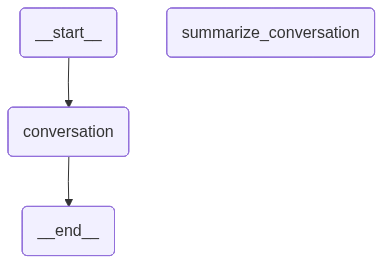

In [11]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

Now, we can invoke the graph several times. 

In [8]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="i like the 49ers!")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Hello again, Lance! It's great to hear from you. If there's anything specific you'd like to discuss or any questions you have, feel free to let me know!
================================== Ai Message ==================================

Your name is Lance! If there's anything else you'd like to talk about or any questions you have, just let me know.
================================== Ai Message ==================================

That's awesome, Lance! The San Francisco 49ers have a rich history and a passionate fan base. Is there a particular player, game, or moment in 49ers history that you really enjoy?


Let's confirm that our state is saved locally.

In [9]:
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content="hi! I'm Lance", additional_kwargs={}, response_metadata={}, id='cc9fa259-dbe5-41bd-ad7c-8b0861e073f9'), AIMessage(content="Hello again, Lance! It's great to hear from you. If there's anything specific you'd like to discuss or any questions you have, feel free to let me know!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 33, 'prompt_tokens': 337, 'total_tokens': 370, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CTtGMloKUKMr3YooLpP4U4BTdy67m', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--812f669f-f85e-4137-bfe3-718e81696ae4-0', usage_metadata={'input_tokens': 337, 'output_

### Persisting state

Using database like Sqlite means state is persisted! 

For example, we can re-start the notebook kernel and see that we can still load from Sqlite DB on disk.


In [10]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content="hi! I'm Lance", additional_kwargs={}, response_metadata={}, id='cc9fa259-dbe5-41bd-ad7c-8b0861e073f9'), AIMessage(content="Hello again, Lance! It's great to hear from you. If there's anything specific you'd like to discuss or any questions you have, feel free to let me know!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 33, 'prompt_tokens': 337, 'total_tokens': 370, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CTtGMloKUKMr3YooLpP4U4BTdy67m', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--812f669f-f85e-4137-bfe3-718e81696ae4-0', usage_metadata={'input_tokens': 337, 'output_

## LangGraph Studio

**⚠️ DISCLAIMER**

Since the filming of these videos, we've updated Studio so that it can be run locally and opened in your browser. This is now the preferred way to run Studio (rather than using the Desktop App as shown in the video). See documentation [here](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server) on the local development server and [here](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server). To start the local development server, run the following command in your terminal in the `/studio` directory in this module:

```
langgraph dev
```

You should see the following output:
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

Open your browser and navigate to the Studio UI: `https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`.

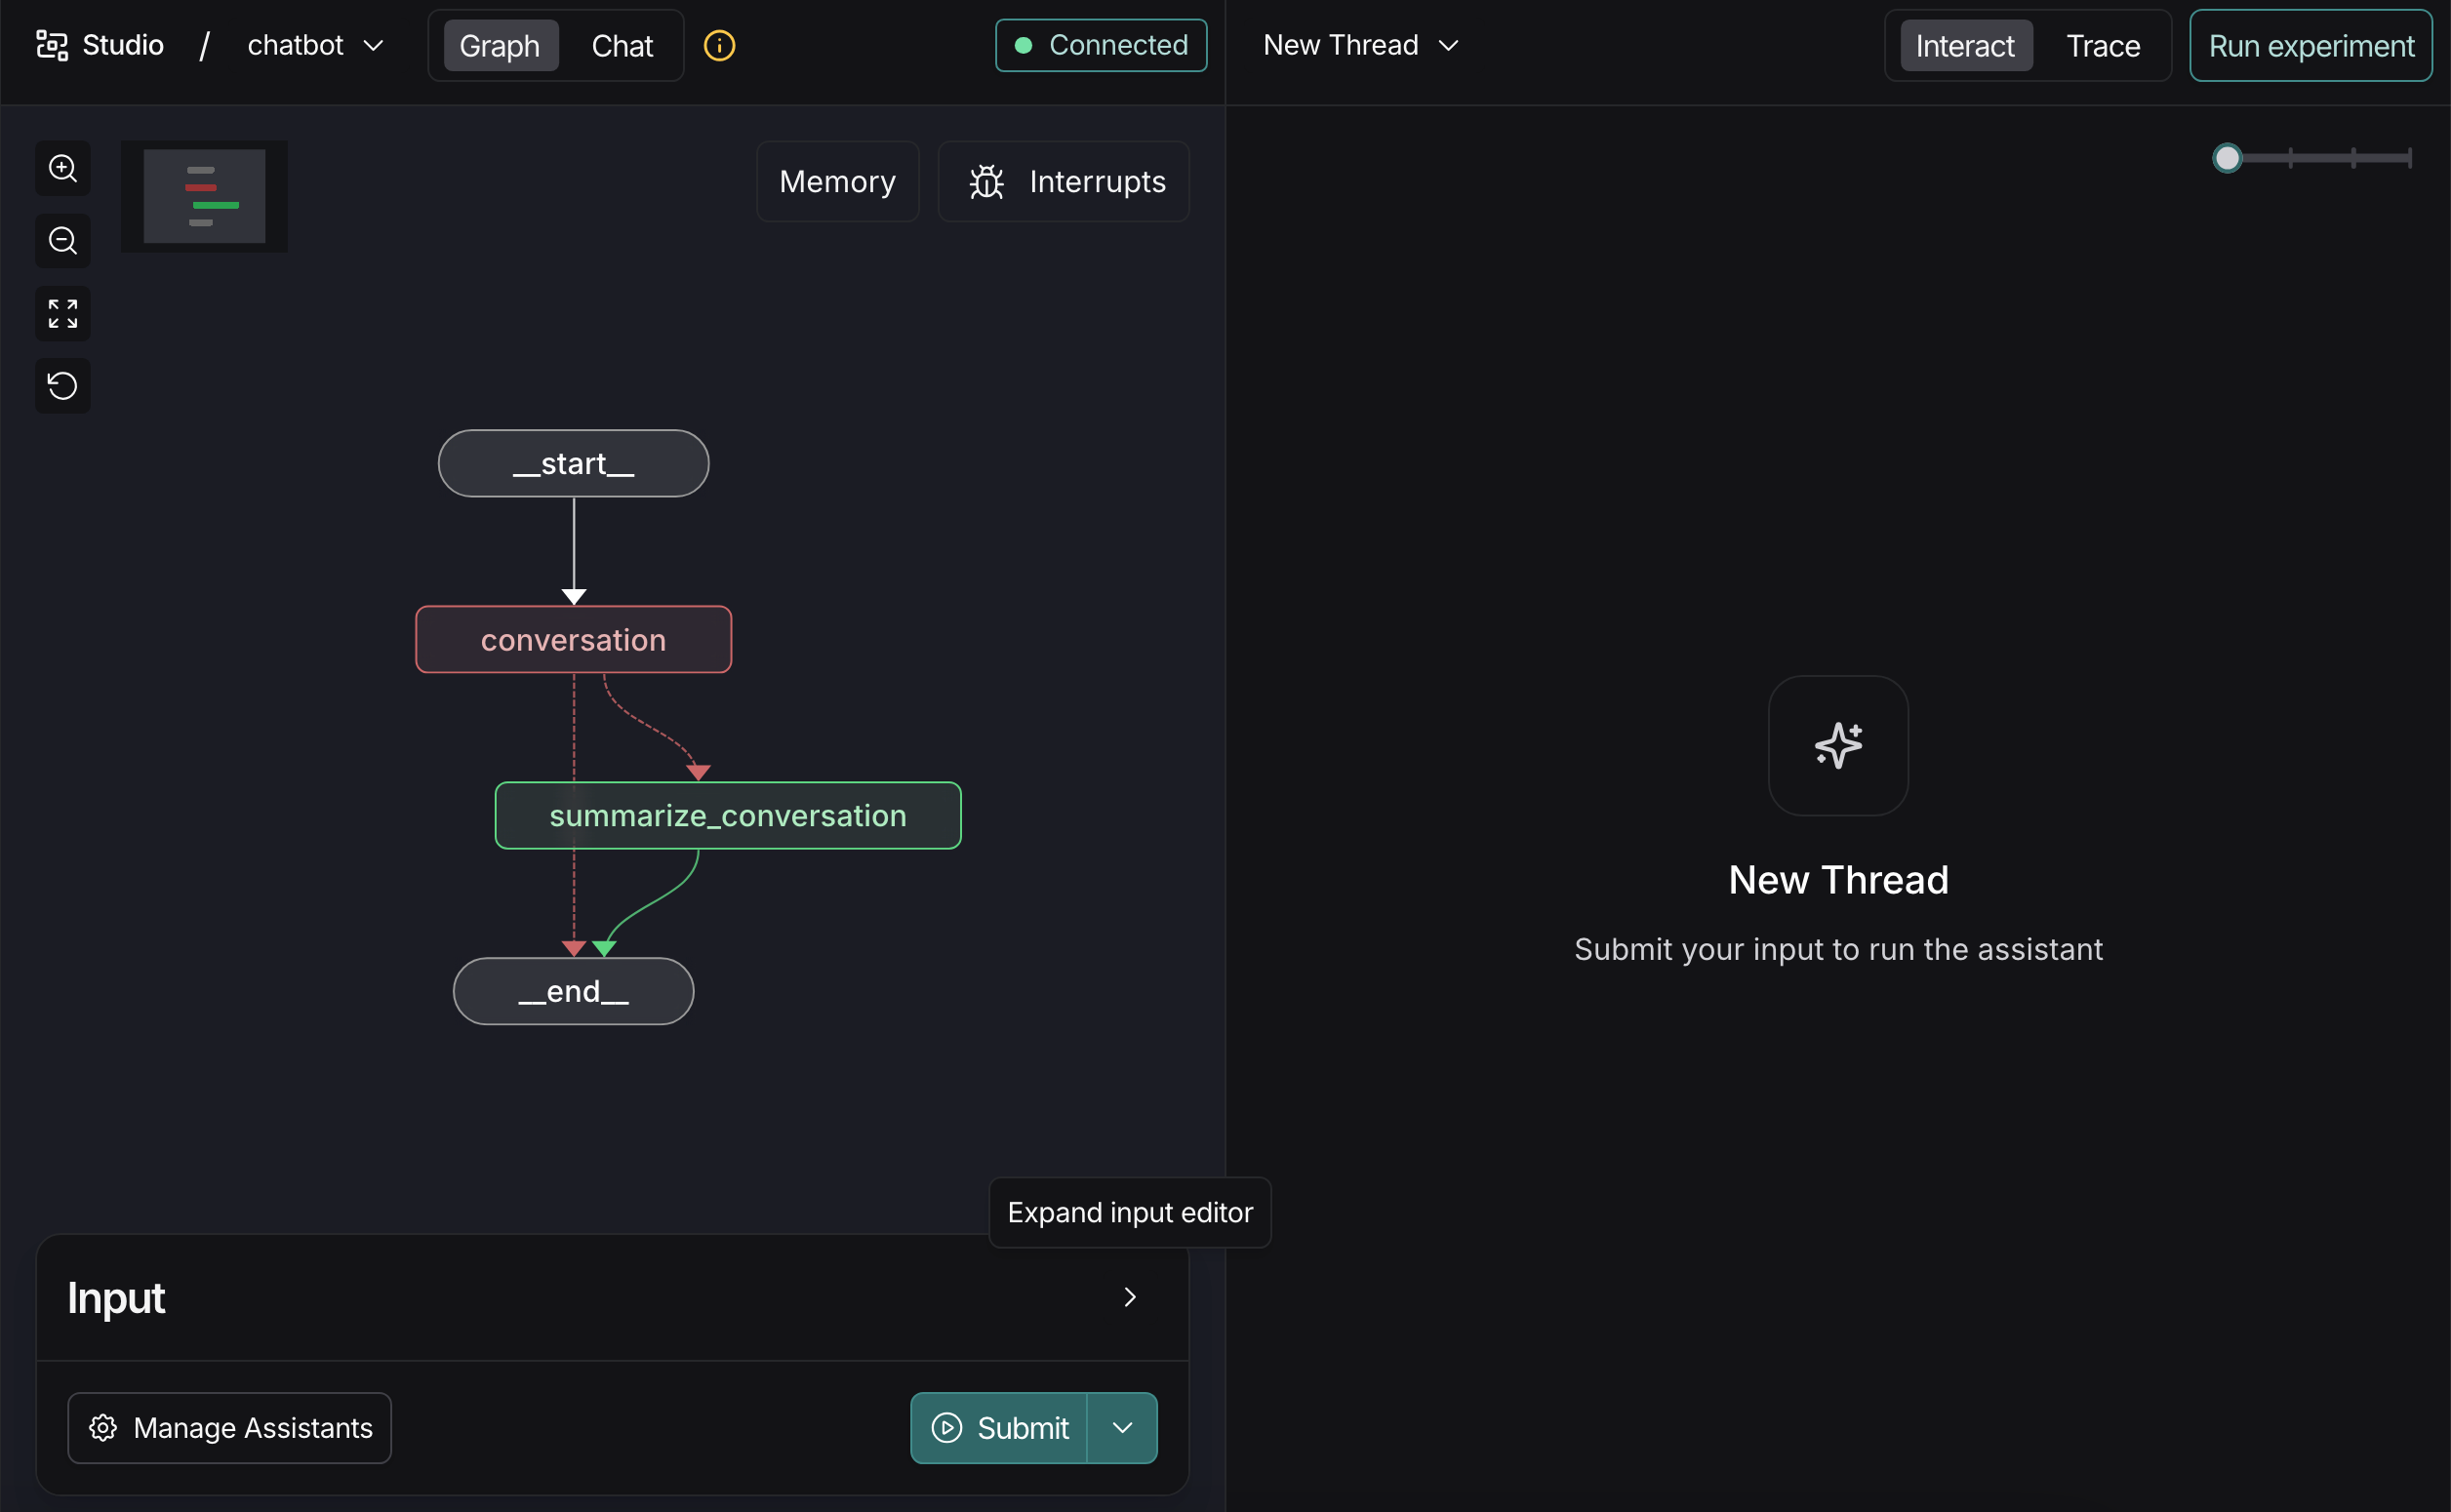
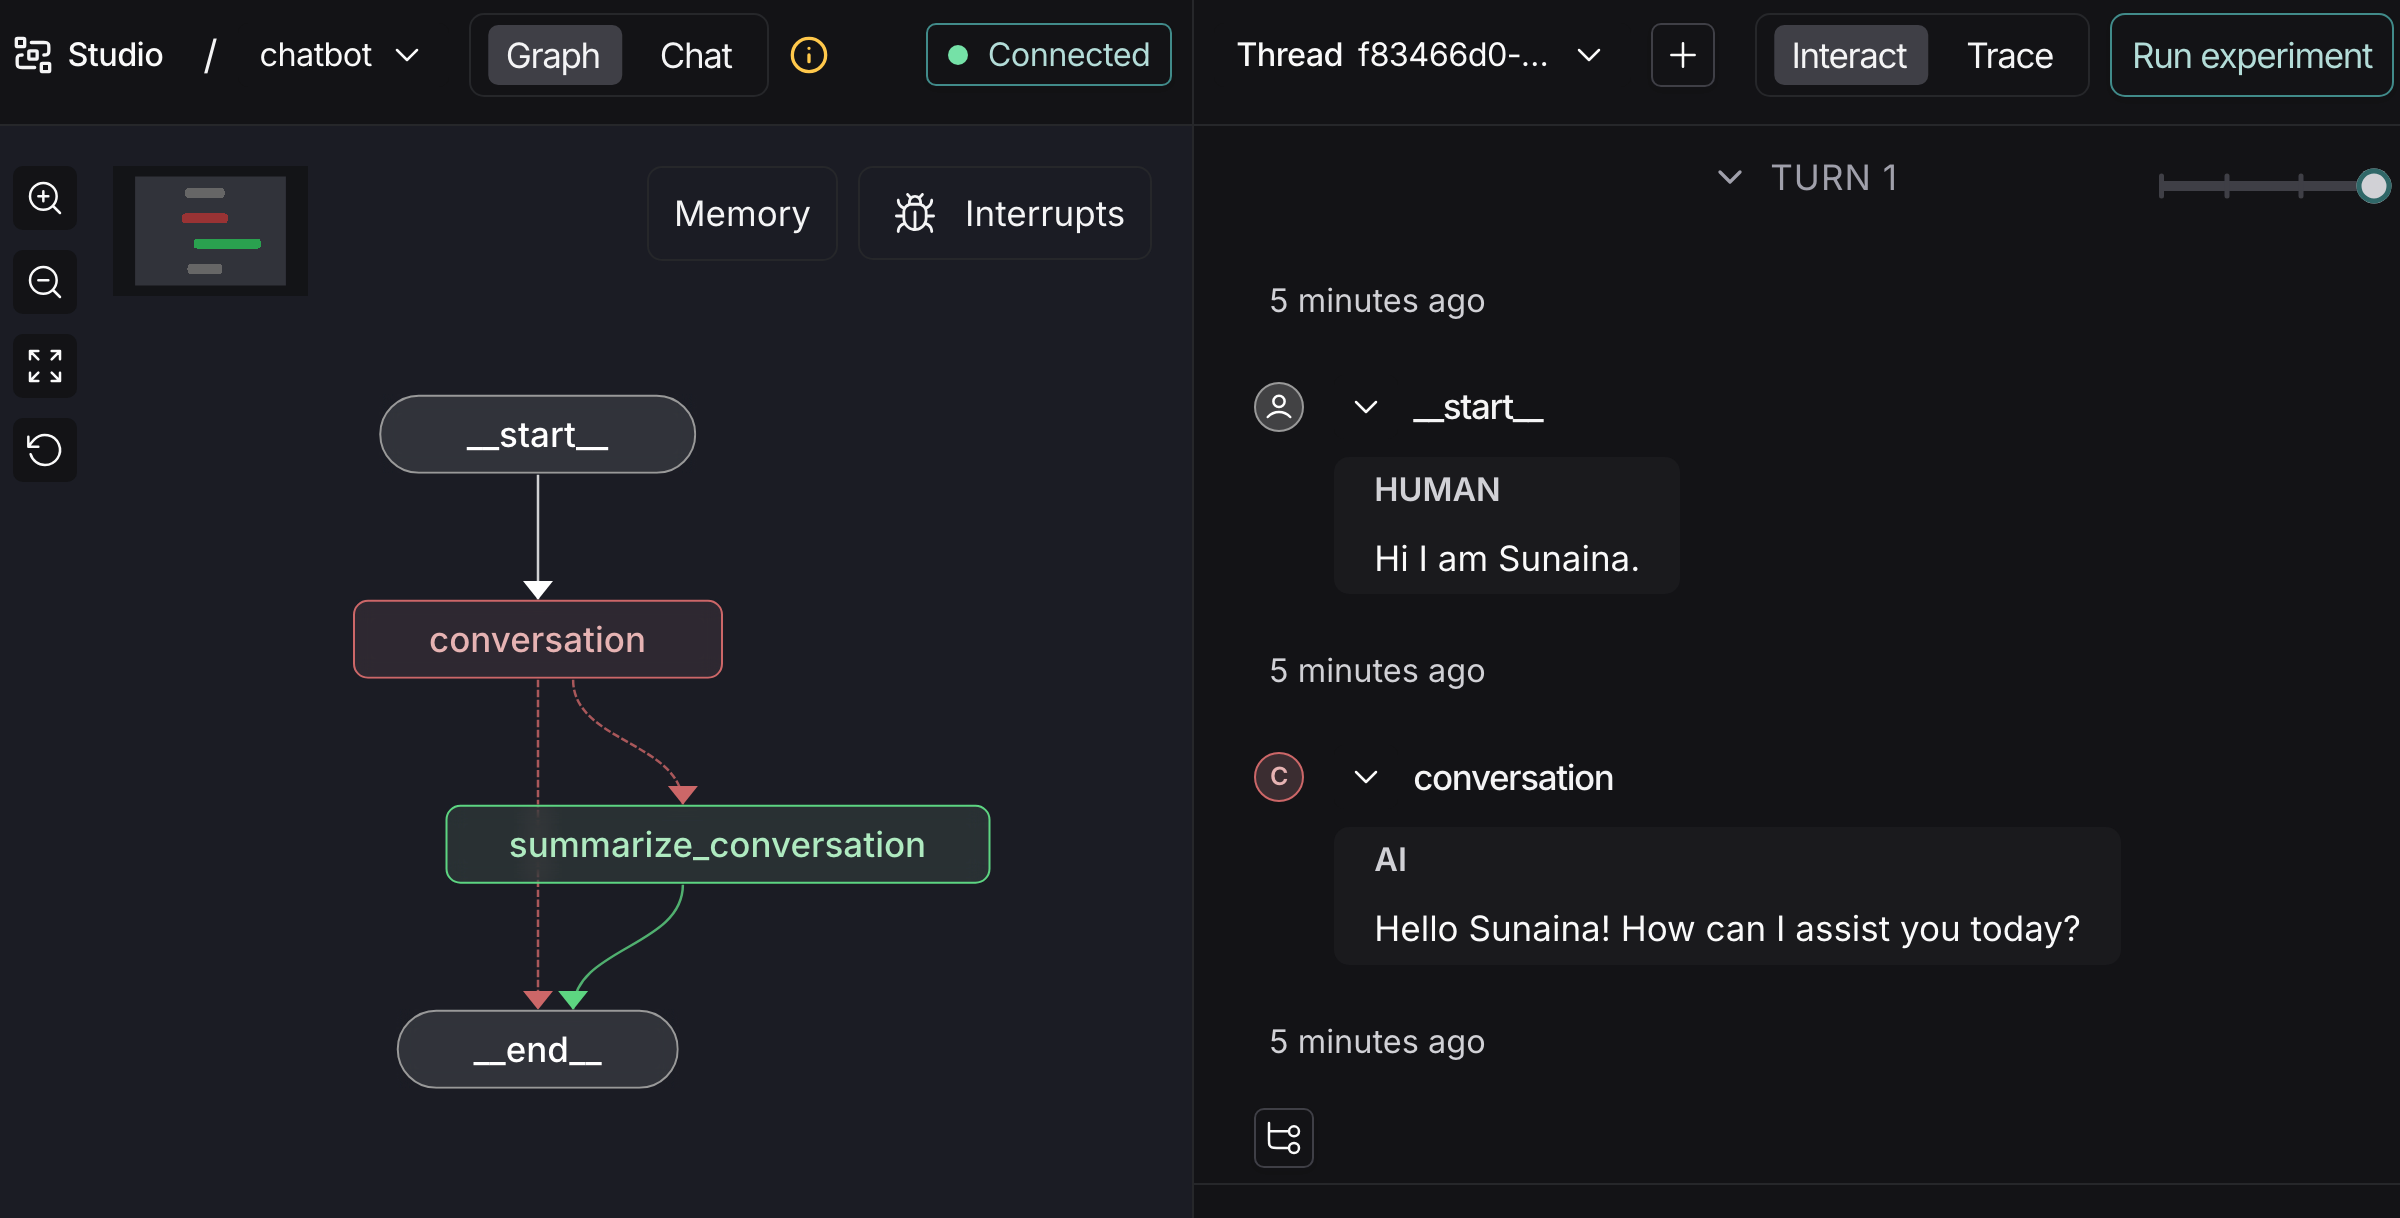
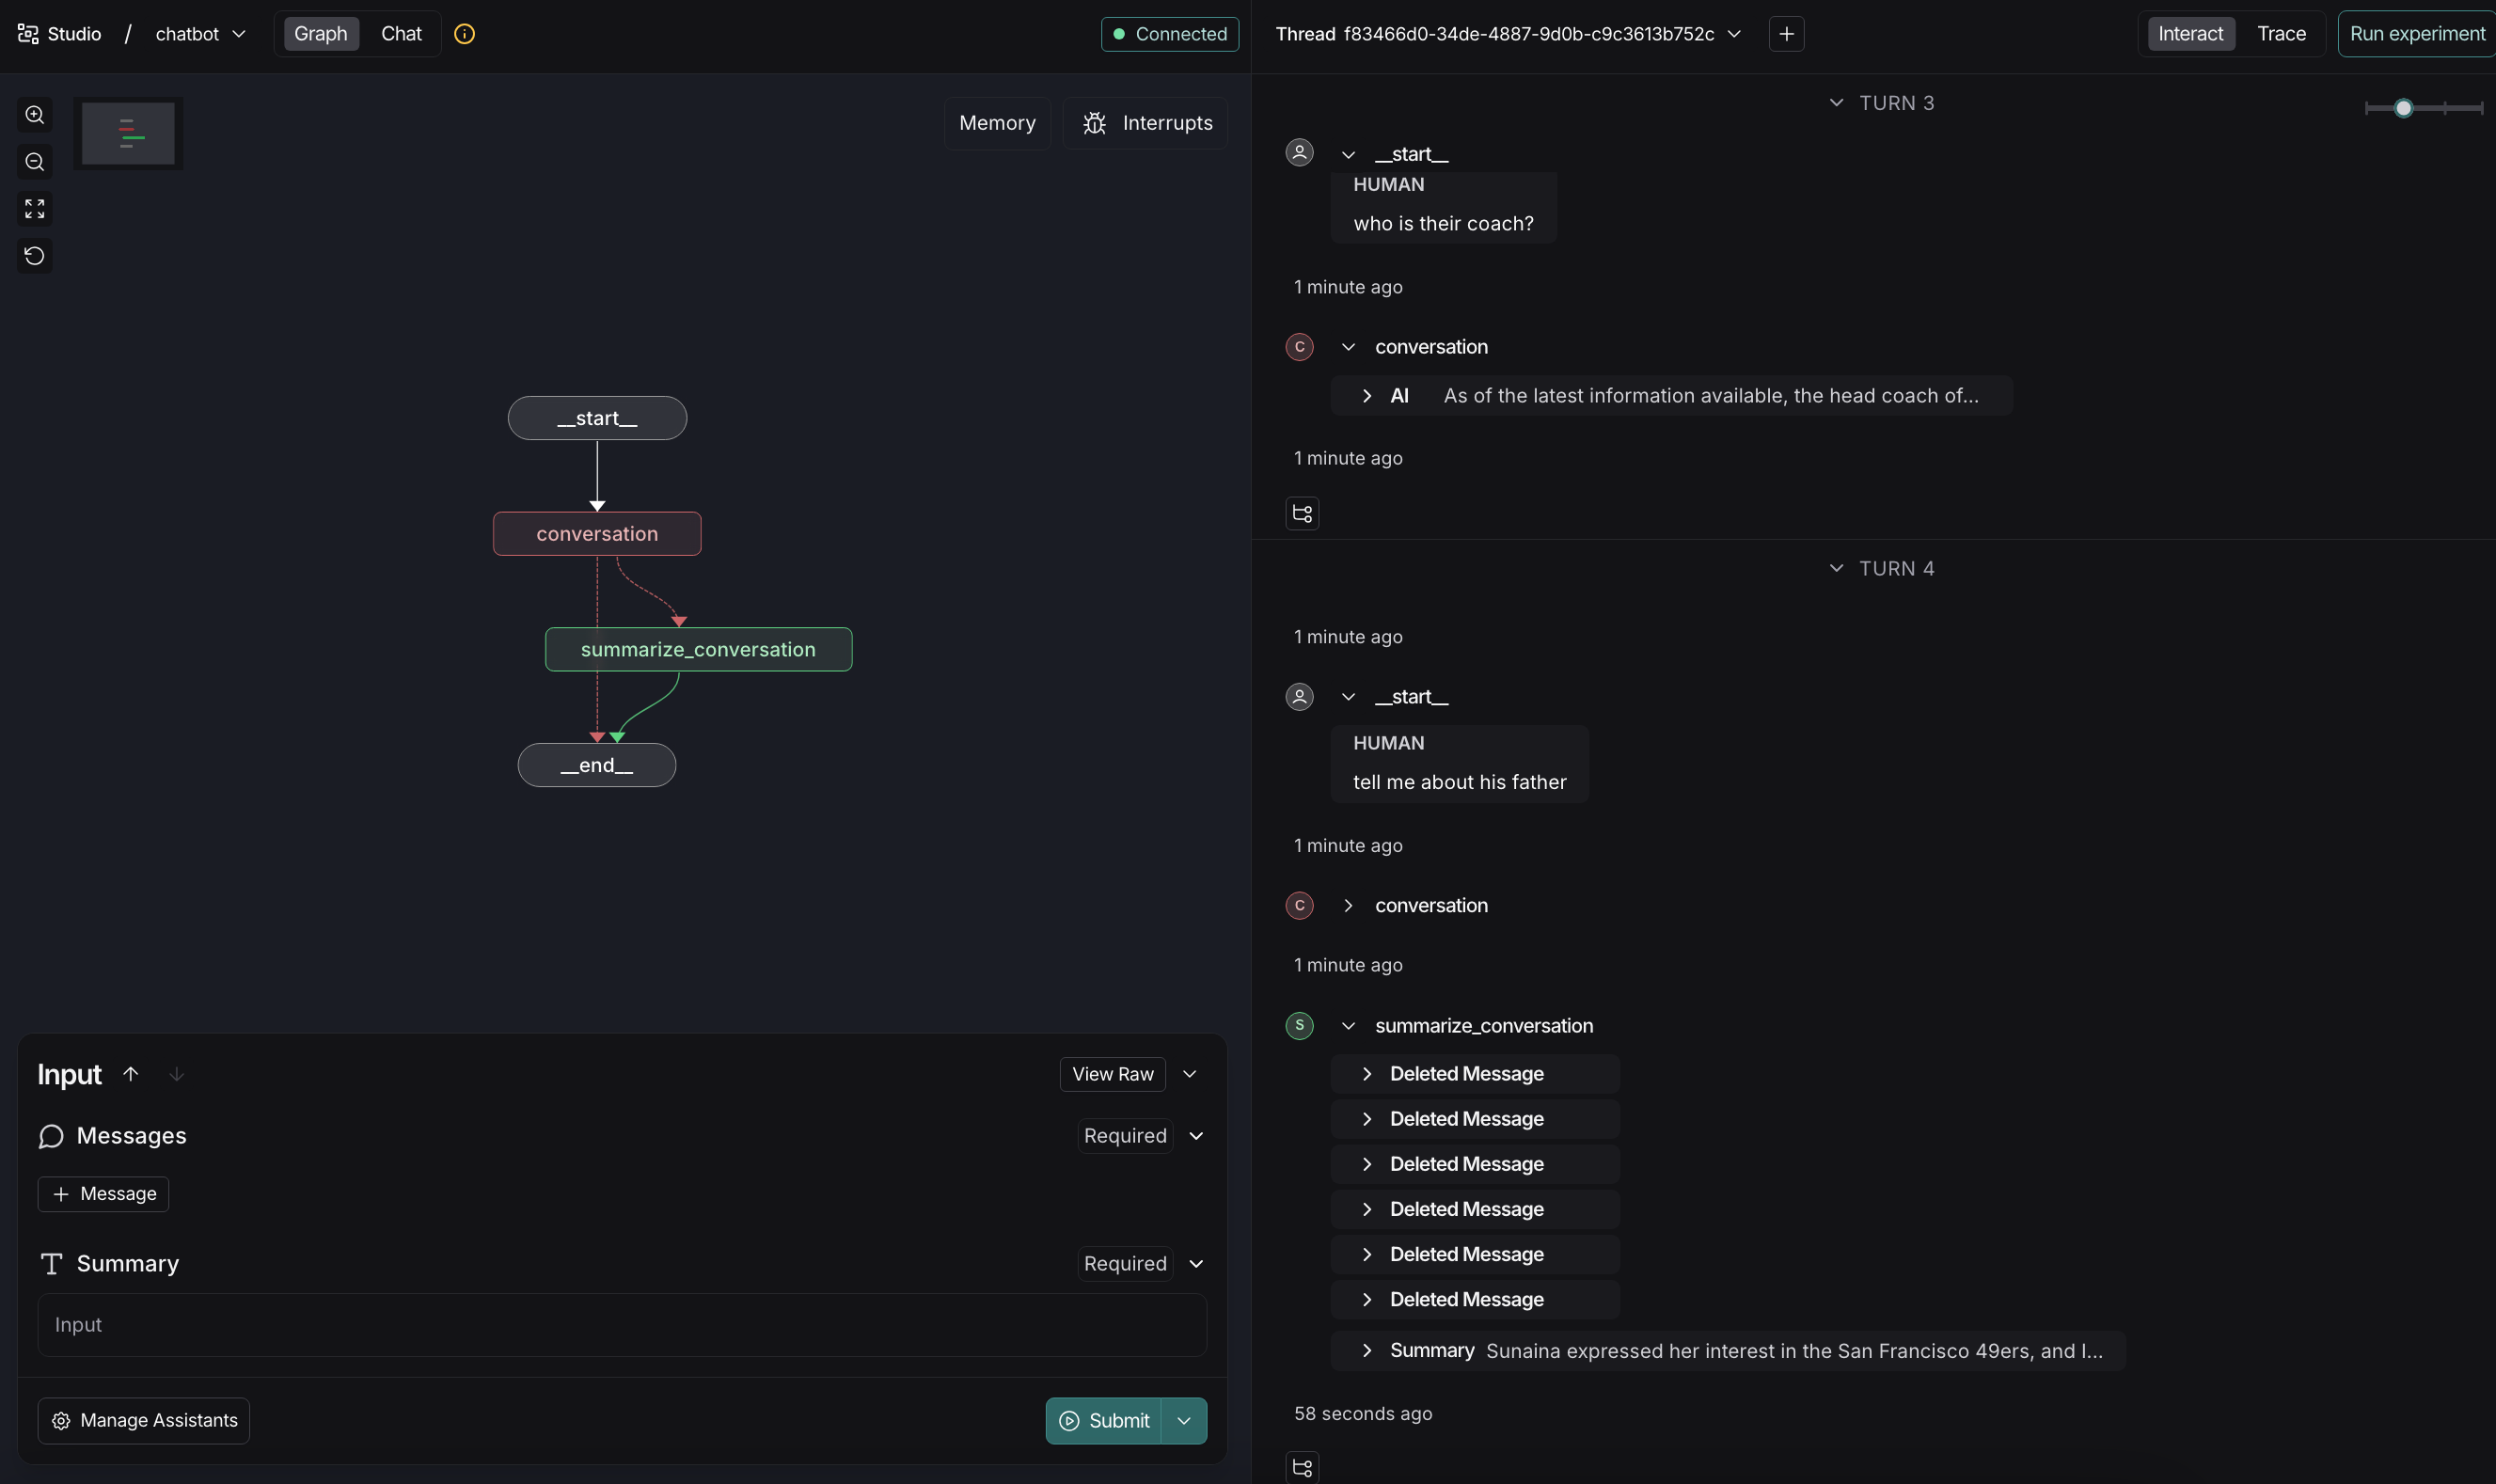

# SELF-EXERCISE:

#### This section sets up the chatbot state and nodes. When the message count exceeds 4, it triggers summarization to update the conversation summary and delete old messages, keeping the context manageable for the model.

In [12]:
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, RemoveMessage
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI

class State(MessagesState):
    summary: str
def call_model(state: State):
    summary = state.get("summary", "")

    if summary:
        system_message = f"Previous conversation summary: {summary}"
        messages = [SystemMessage(content=system_message)] + state["messages"]
    else:
        messages = state["messages"]

    response = model.invoke(messages)
    return {"messages": response}

def summarize_conversation(state: State):
    summary = state.get("summary", "")

    if summary:
        summary_message = (
            f"Current summary: {summary}\n\n"
            "Update this summary with the new messages above:"
        )
    else:
        summary_message = "Create a brief summary of this conversation:"

    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)

    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]

    return {"summary": response.content, "messages": delete_messages}

def should_continue(state: State):
    messages = state["messages"]

    if len(messages) > 4:
        return "summarize_conversation"

    return END

#### Building and Compiling the Graph

In [13]:
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node("summarize_conversation", summarize_conversation)

workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)

#### Simulated a casual chat where the user asks about the weather and activities. Each message updates the conversation state, invoking the model and printing responses.

In [14]:
config = {"configurable": {"thread_id": "chat-thread-1"}}

input_message = HumanMessage(content="Hi! How’s the weather today?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="Can you suggest some weekend activities?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="I prefer outdoor activities.")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="Thanks, that helps a lot!")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

I'm sorry, but I can't provide real-time weather updates. You might want to check a reliable weather website or app for the most current information.
================================== Ai Message ==================================

Certainly! Here are some weekend activity ideas:

1. **Outdoor Adventures**: Go for a hike, bike ride, or a picnic in a local park. If you're near water, consider kayaking or paddleboarding.

2. **Cultural Experiences**: Visit a museum, art gallery, or historical site. Check if there are any local festivals or events happening.

3. **Relaxation**: Spend a day at a spa, do some yoga, or have a leisurely day at home with a good book or movie marathon.

4. **Cooking or Baking**: Try out a new recipe or bake some treats. You could even host a small dinner party for friends or family.

5. **DIY Projects**: Tackle a home improvement project or get creative with some arts and crafts.


#### Retrieved and printed the conversation summary before and after continuing the chat, showing how the summary updates dynamically as the conversation grows.

In [15]:
summary = graph.get_state(config).values.get("summary", "")
print("Conversation Summary:", summary)

Conversation Summary: The user inquired about the current weather, and I suggested checking a reliable source for real-time updates. They then asked for weekend activity ideas, expressing a preference for outdoor activities. I provided a list of outdoor options, including hiking, cycling, picnicking, camping, kayaking, rock climbing, bird watching, fishing, beach outings, and photography walks, emphasizing safety and preparation.


In [16]:
input_message = HumanMessage(content="What should I plan for next weekend?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Planning for next weekend can be exciting! Here are a few steps and ideas to help you decide:

1. **Check the Weather**: Start by checking the weather forecast for next weekend. This will help you choose activities that are suitable for the conditions.

2. **Consider Your Interests**: Think about what you enjoy most. Do you prefer relaxing activities, or are you looking for something more adventurous?

3. **Explore New Places**: If you're up for it, consider visiting a place you haven't been to before. It could be a nearby town, a new hiking trail, or a different park.

4. **Plan with Friends or Family**: If you enjoy company, see if friends or family are available to join you. Activities can be more fun with others.

5. **Outdoor Activity Ideas**:
   - **Hiking or Nature Walk**: Find a new trail or nature reserve to explore.
   - **Camping Trip**: Plan a weekend camping trip to a nearby campsite.
   - **

In [17]:
summary = graph.get_state(config).values.get("summary", "")
print("Updated Summary:", summary)

Updated Summary: The user expressed a preference for outdoor activities, and I provided a list of options such as hiking, cycling, picnicking, camping, kayaking, rock climbing, bird watching, fishing, beach outings, and photography walks, emphasizing safety and preparation. They then asked for suggestions on what to plan for the next weekend. I advised checking the weather, considering personal interests, exploring new places, and planning with friends or family. I offered specific outdoor activity ideas like hiking, camping, beach or lake days, picnics, cycling adventures, visiting a farmers' market, and outdoor yoga or meditation. I also recommended preparing in advance and staying flexible with plans.


#### Displayed the entire graph state for the current thread to inspect stored values and messages.

In [18]:
graph_state = graph.get_state(config)
print(graph_state)

StateSnapshot(values={'messages': [HumanMessage(content='What should I plan for next weekend?', additional_kwargs={}, response_metadata={}, id='f8e83334-5747-42db-86b9-d28d3ad21fa6'), AIMessage(content="Planning for next weekend can be exciting! Here are a few steps and ideas to help you decide:\n\n1. **Check the Weather**: Start by checking the weather forecast for next weekend. This will help you choose activities that are suitable for the conditions.\n\n2. **Consider Your Interests**: Think about what you enjoy most. Do you prefer relaxing activities, or are you looking for something more adventurous?\n\n3. **Explore New Places**: If you're up for it, consider visiting a place you haven't been to before. It could be a nearby town, a new hiking trail, or a different park.\n\n4. **Plan with Friends or Family**: If you enjoy company, see if friends or family are available to join you. Activities can be more fun with others.\n\n5. **Outdoor Activity Ideas**:\n   - **Hiking or Nature Wal

# LANGGRAPH STUDIO INTERFACE:

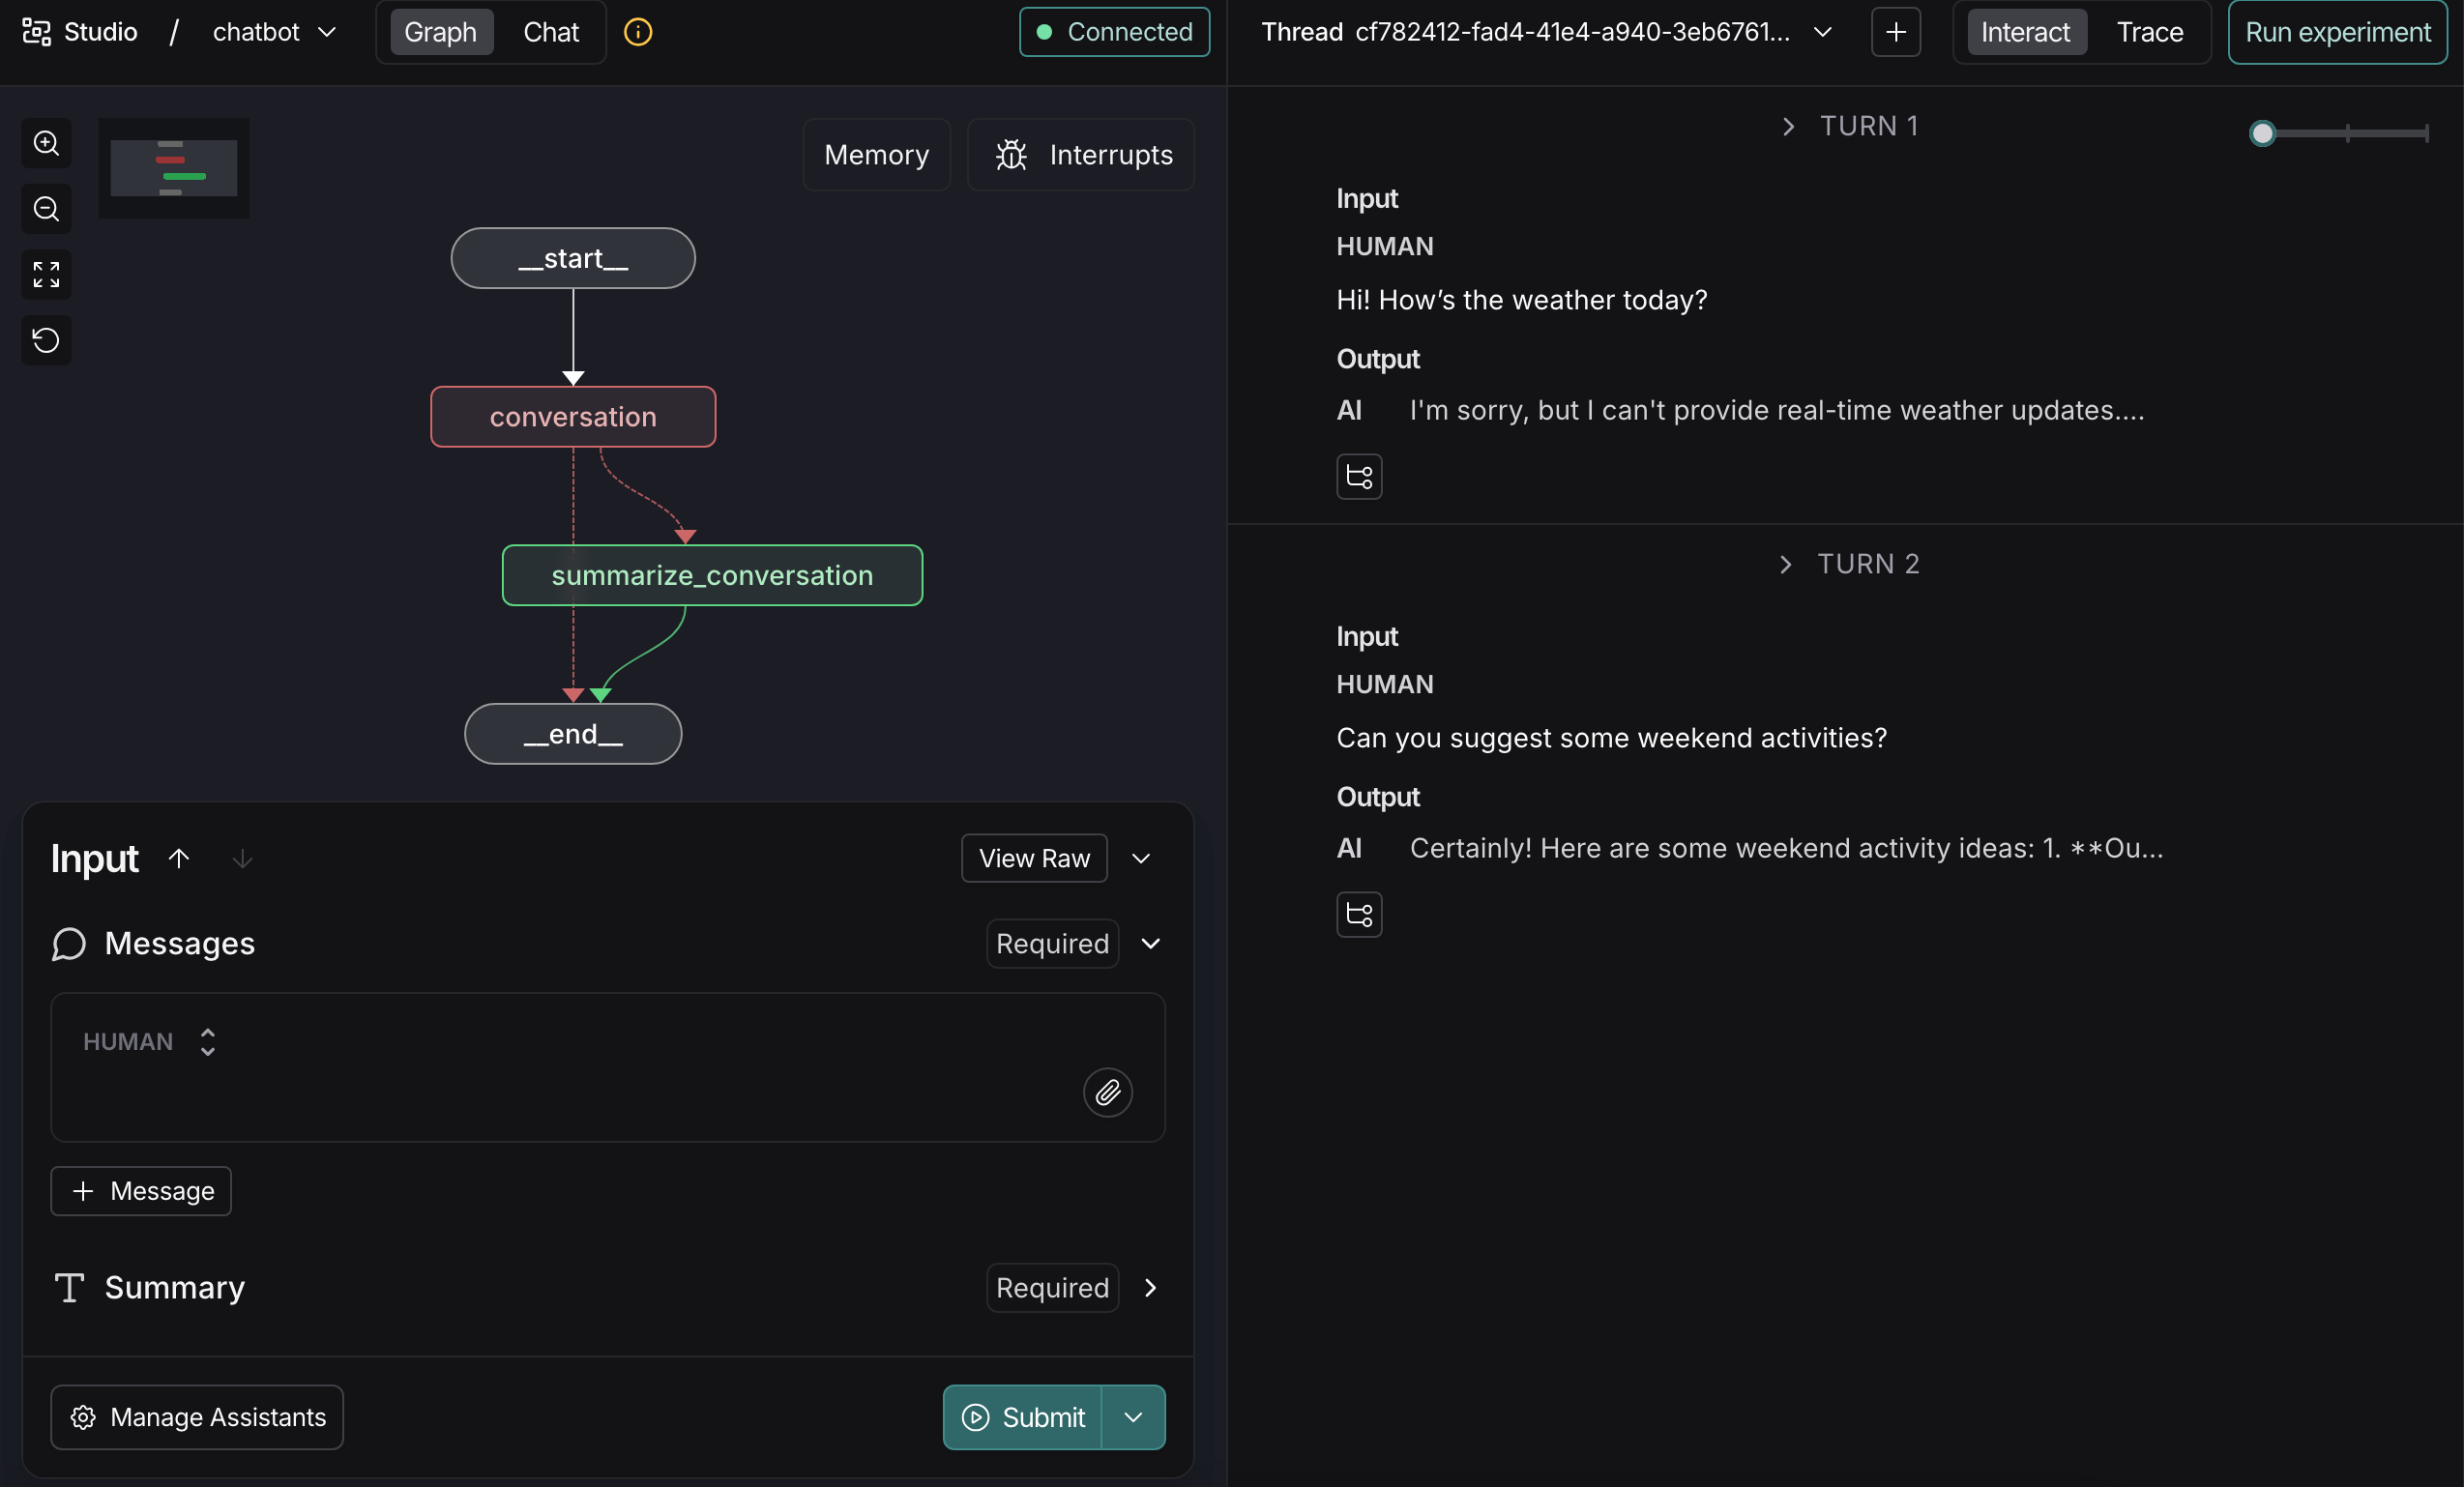

**When message count exceeded 4, it triggered summarization**

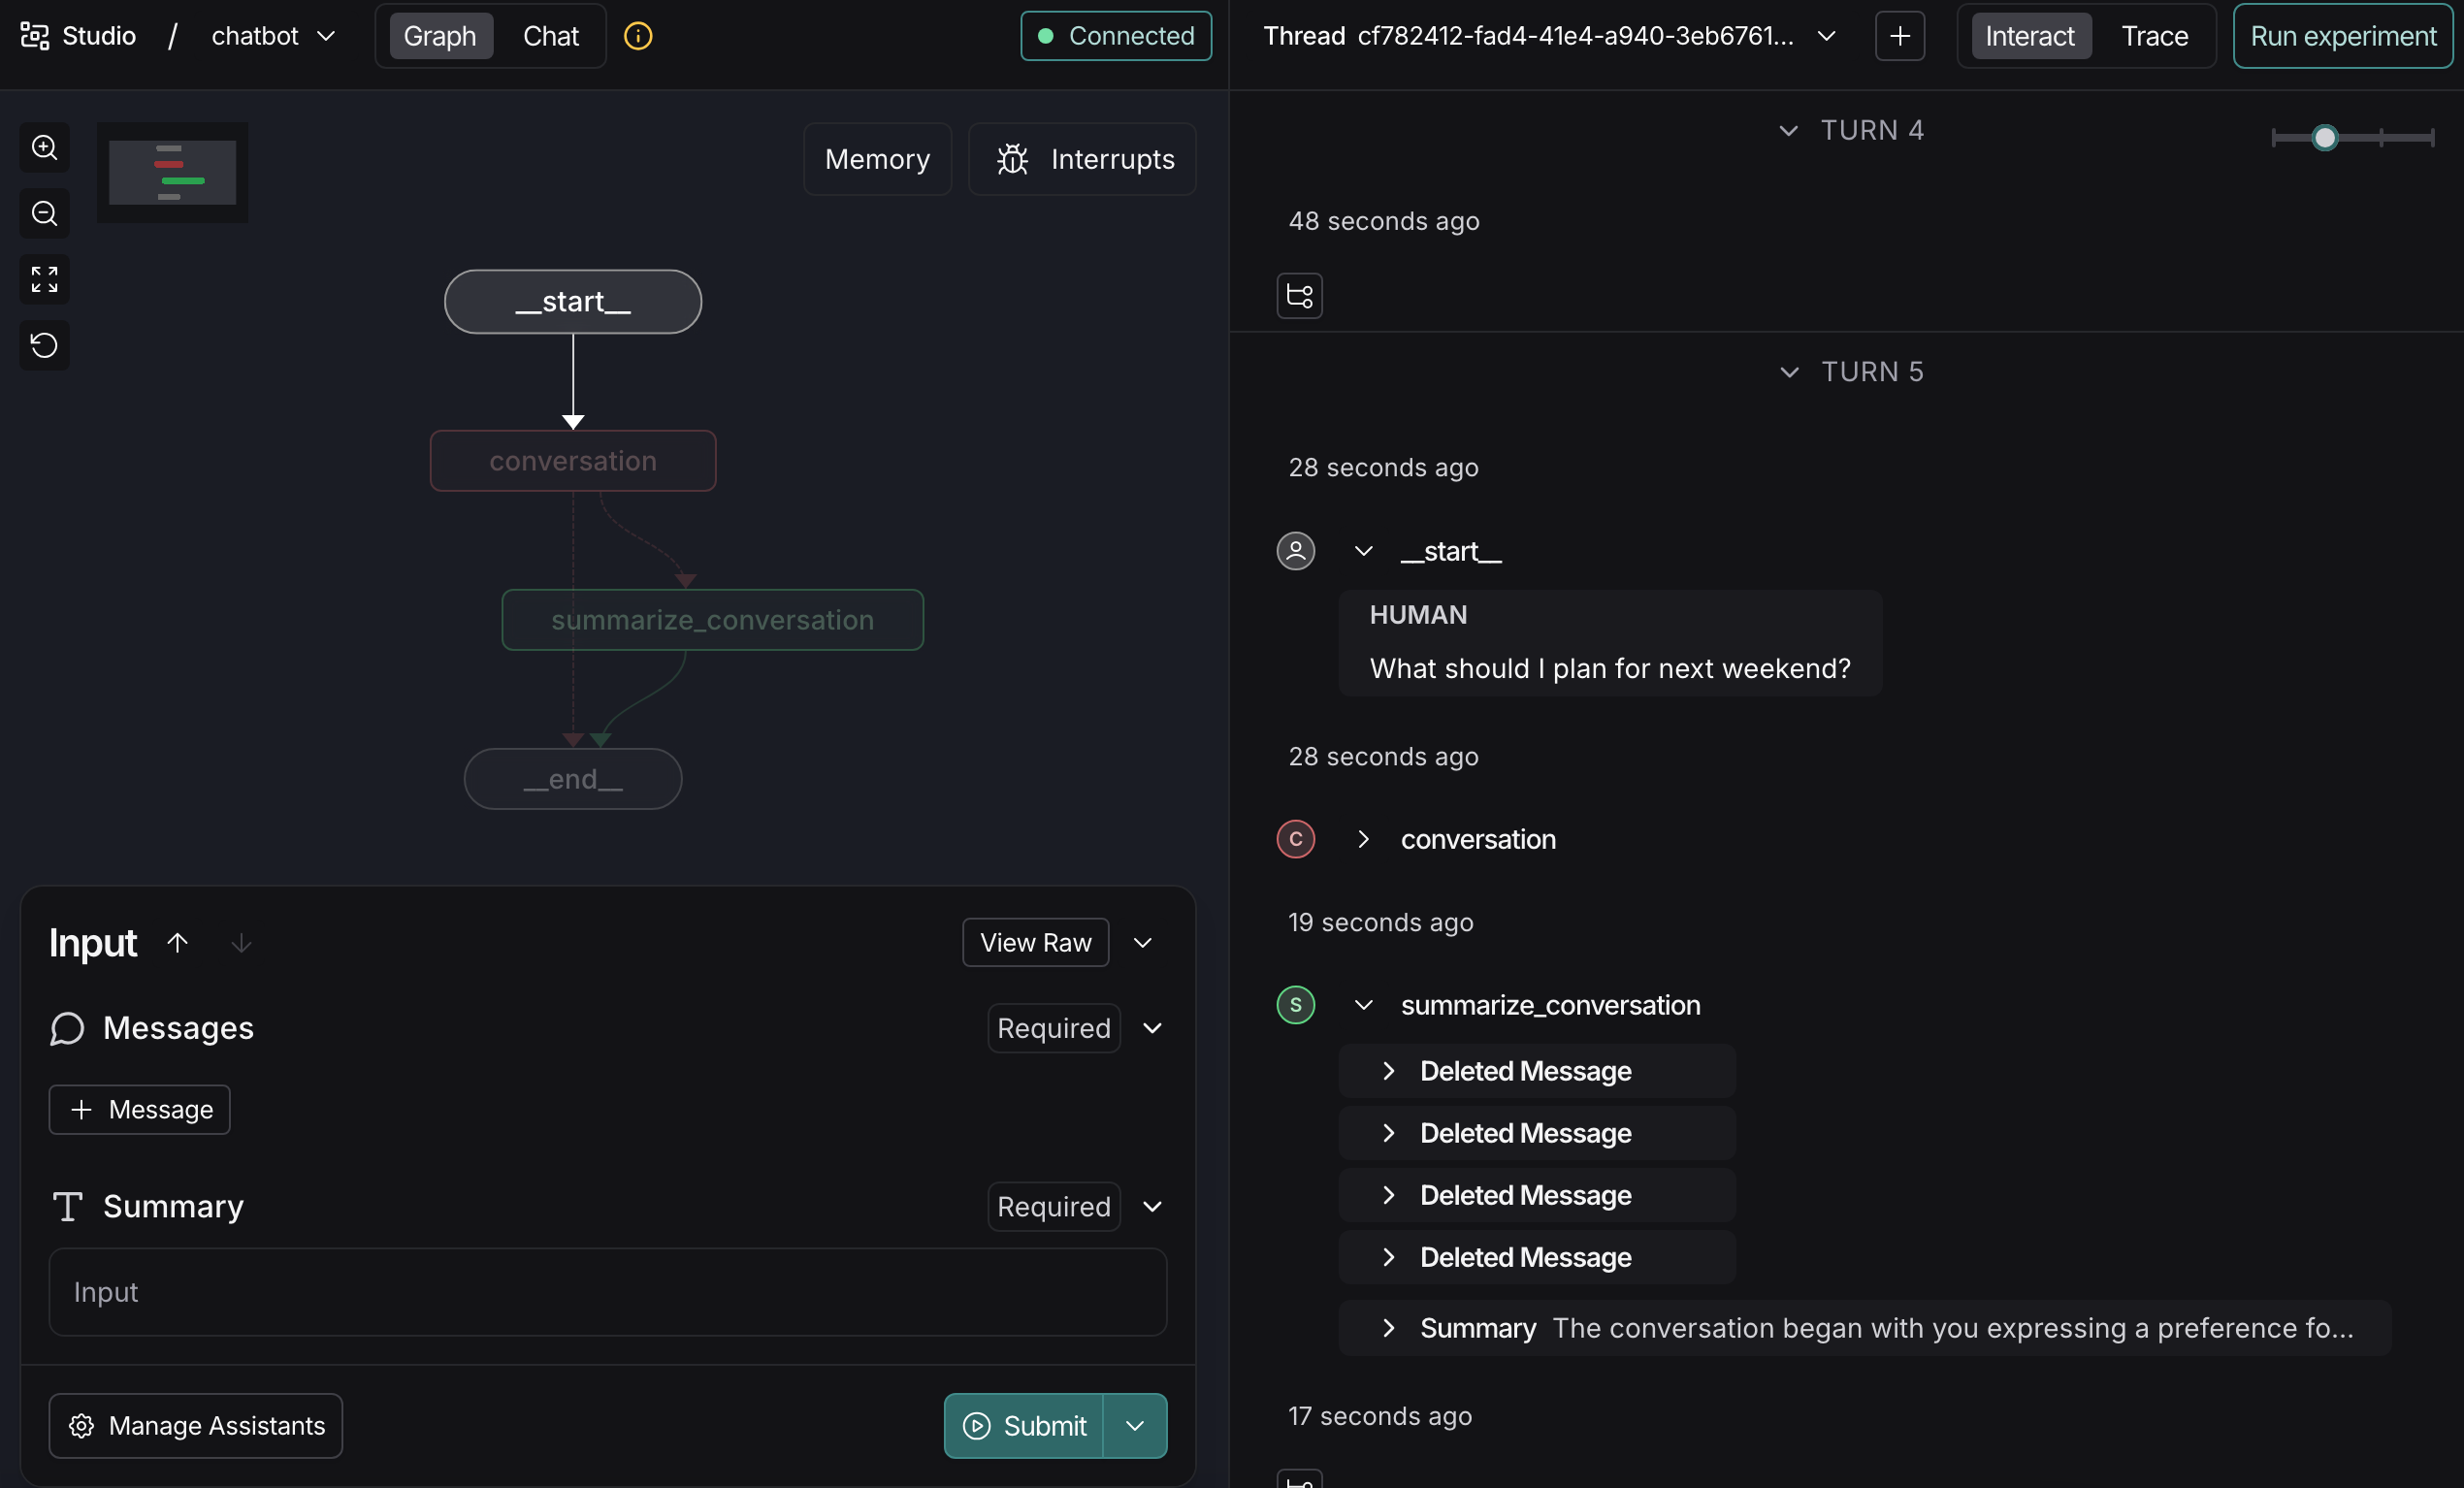